# **Import Library**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from wordcloud import WordCloud
import requests
import json
import time
from collections import Counter
import warnings
import plotly.express as px
from plotly.subplots import make_subplots

warnings.filterwarnings('ignore')

# Install required packages
!pip install replicate -q
!pip install wordcloud -q
!pip install textstat -q

import replicate
import textstat

# Download NLTK data
nltk.download('punkt')
nltk.download('stopwords')

print("✅ All libraries imported successfully!")
print("📝 Starting Text Summarization Analysis...")


✅ All libraries imported successfully!
📝 Starting Text Summarization Analysis...


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# **REPLICATE API SETUP**

Potongan kode ini berfungsi untuk **mengatur dan menguji koneksi ke Replicate API** agar model IBM Granite bisa digunakan.

Ringkasannya:

1. **Meminta API Token dari pengguna**

   * User diminta memasukkan *Replicate API token* melalui `input()`.
   * Token disimpan di `os.environ["REPLICATE_API_TOKEN"]`.

2. **Menguji koneksi API**

   * Fungsi `test_replicate_connection()` mencoba menjalankan model *ibm-granite/granite-3.2-8b-instruct* dengan prompt sederhana.
   * Jika berhasil, tampil pesan ✅ sukses, kalau gagal akan muncul ❌ error beserta penyebabnya.

3. **Hasil uji koneksi** disimpan di variabel `api_ready` untuk dipakai di tahap analisis berikutnya.


In [ ]:
print("\n" + "="*60)
print("🔑 REPLICATE API SETUP")
print("="*60)

# Set up Replicate API
print("Please enter your Replicate API token:")
api_token = input("Replicate API Token: ")

# Configure Replicate client
import os
os.environ["REPLICATE_API_TOKEN"] = api_token

print("✅ Replicate API configured successfully!")

# Test API connection
def test_replicate_connection():
    try:
        # Test with a simple text
        output = replicate.run(
            "ibm-granite/granite-3.2-8b-instruct",
            input={
                "prompt": "Hello, this is a test message.",
                "max_tokens": 50
            }
        )
        print("✅ API connection successful!")
        return True
    except Exception as e:
        print(f"❌ API connection failed: {str(e)}")
        return False

# Test connection
api_ready = test_replicate_connection()


🔑 REPLICATE API SETUP
Please enter your Replicate API token:
Replicate API Token: r8_NNWuyGbkNWTG8GIBWkLnHADTZ8wo10b13D11c
✅ Replicate API configured successfully!
✅ API connection successful!


# **LOAD AND PREPARE DATA**

In [ ]:
print("\n" + "="*60)
print("📁 DATA LOADING AND PREPARATION")
print("="*60)

# Upload dataset
from google.colab import files

print("📁 Please upload your AI Assistant Usage dataset:")
uploaded = files.upload()

filename = list(uploaded.keys())[0]
# ⬇️ Hanya baca 111 baris pertama
df = pd.read_csv(filename, nrows=111)

print(f"✅ Dataset loaded: {df.shape[0]} rows × {df.shape[1]} columns")

# Identify text columns for summarization
text_columns = []
for col in df.columns:
    if df[col].dtype == 'object':
        # Check average text length
        non_null_data = df[col].dropna()
        if len(non_null_data) > 0:
            avg_length = non_null_data.astype(str).str.len().mean()
            if avg_length > 50:  # Likely text data
                text_columns.append(col)

print(f"📝 Text columns identified: {text_columns}")

# If no text columns found, create sample data
if not text_columns:
    print("⚠️ No text columns found. Creating sample feedback data...")

    sample_feedback = [
        "AI assistants have revolutionized my study habits. I use them daily for research, essay writing, and problem-solving. They help me understand complex topics faster and provide instant feedback on my work.",
        "The AI tool helps me with coding assignments and debugging. It's like having a tutor available 24/7. However, I worry about becoming too dependent on it for basic tasks.",
        "I love using AI for creative writing projects. It gives me inspiration and helps overcome writer's block. The suggestions are usually relevant and spark new ideas.",
        "AI assistants are great for language learning. They correct my grammar, suggest better phrases, and help with pronunciation. My English has improved significantly since I started using them.",
        "Sometimes I feel overwhelmed by AI capabilities. While it's helpful for assignments, I question whether I'm actually learning or just getting answers. Balance is important.",
        "The AI helps me organize my study schedule and set priorities. It reminds me of deadlines and suggests efficient study methods. My productivity has increased dramatically.",
        "I use AI for math problem solving and it explains step-by-step solutions. This helps me understand the methodology rather than just getting the answer.",
        "Research papers are much easier to write with AI assistance. It helps find relevant sources, suggests outlines, and improves my argumentation structure.",
        "AI tutoring sessions are personalized to my learning style. The system adapts to my pace and focuses on areas where I struggle most.",
        "Privacy concerns make me cautious about sharing personal academic work with AI systems. I prefer using it for general queries rather than sensitive assignments."
    ]

    df['student_feedback'] = np.random.choice(sample_feedback, size=len(df))
    text_columns = ['student_feedback']
    print("✅ Sample feedback data created")

# Display text data statistics
for col in text_columns:
    print(f"\n📊 Text Statistics for '{col}':")
    text_data = df[col].dropna().astype(str)
    print(f"   📏 Total texts: {len(text_data)}")
    print(f"   📐 Avg length: {text_data.str.len().mean():.1f} characters")
    print(f"   📊 Min length: {text_data.str.len().min()} characters")
    print(f"   📈 Max length: {text_data.str.len().max()} characters")

    # Show sample
    print(f"   📝 Sample text:")
    sample_text = text_data.iloc[0][:200] + "..." if len(text_data.iloc[0]) > 200 else text_data.iloc[0]
    print(f"      {sample_text}")



📁 DATA LOADING AND PREPARATION
📁 Please upload your AI Assistant Usage dataset:


Saving ai_assistant_usage_student_life.csv to ai_assistant_usage_student_life (1).csv
✅ Dataset loaded: 111 rows × 11 columns
📝 Text columns identified: []
⚠️ No text columns found. Creating sample feedback data...
✅ Sample feedback data created

📊 Text Statistics for 'student_feedback':
   📏 Total texts: 111
   📐 Avg length: 162.6 characters
   📊 Min length: 132 characters
   📈 Max length: 204 characters
   📝 Sample text:
      I use AI for math problem solving and it explains step-by-step solutions. This helps me understand the methodology rather than just getting the answer.


# **TEXT PREPROCESSING FOR SUMMARIZATION**

Potongan kode ini adalah tahap **preprocessing ringan untuk summarization**.

Ringkasan langkahnya:

1. **Fungsi `preprocess_for_summarization(text)`**

   * Mengubah nilai NaN menjadi string kosong.
   * Menghapus spasi berlebih (`\s+`) tapi **tetap menjaga struktur kalimat**.
   * Menghapus spasi di awal/akhir teks.

2. **Penerapan pada setiap kolom teks (`text_columns`)**

   * Menampilkan nama kolom yang sedang diproses.
   * Menyimpan hasil preprocessing ke `preprocessed_data`.
   * Menghitung statistik pasca-preprocessing:

     * Jumlah teks yang berhasil diproses.
     * Rata-rata panjang teks (dalam karakter).


In [ ]:
print("\n" + "="*60)
print("🔧 TEXT PREPROCESSING")
print("="*60)

def preprocess_for_summarization(text):
    """
    Light preprocessing for summarization (preserve structure)
    """
    if pd.isna(text):
        return ""

    text = str(text)
    # Remove excessive whitespace but preserve sentence structure
    text = re.sub(r'\s+', ' ', text)
    text = text.strip()

    return text

# Apply preprocessing
preprocessed_data = {}
for col in text_columns:
    print(f"🔄 Preprocessing text column: {col}")
    preprocessed_data[col] = df[col].apply(preprocess_for_summarization)

    # Statistics after preprocessing
    clean_texts = preprocessed_data[col][preprocessed_data[col] != ""]
    print(f"   ✅ Processed {len(clean_texts)} texts")
    print(f"   📊 Avg length after preprocessing: {clean_texts.str.len().mean():.1f} characters")



🔧 TEXT PREPROCESSING
🔄 Preprocessing text column: student_feedback
   ✅ Processed 111 texts
   📊 Avg length after preprocessing: 162.6 characters


# **INDIVIDUAL TEXT SUMMARIZATION**

Kode ini melakukan **ringkasan teks individual** menggunakan model IBM Granite.
Langkahnya:

1. **Fungsi `summarize_with_granite`**

   * Menerima teks dan batas kata (`max_words`).
   * Mengirim prompt ke model *IBM Granite* via API untuk membuat ringkasan singkat.
   * Menangani error jika API tidak tersedia atau terjadi kegagalan.

2. **Proses ringkasan sampel**

   * Mengambil maksimal 10 teks contoh dari kolom teks utama.
   * Menampilkan teks asli (maks 200 karakter) dan hasil ringkasannya.
   * Menghitung **compression ratio** untuk menunjukkan seberapa besar teks dipadatkan.
   * Memberi jeda waktu untuk menghindari *rate limiting* API.


In [ ]:
print("\n" + "="*60)
print("📝 INDIVIDUAL TEXT SUMMARIZATION")
print("="*60)

def summarize_with_granite(text, max_words=50):
    """
    Summarize text using IBM Granite model
    """
    if not api_ready:
        return f"API not available. Sample summary of: {text[:100]}..."

    try:
        prompt = f"""Please provide a concise summary of the following text in {max_words} words or less:

Text: {text}

Summary:"""

        output = replicate.run(
            "ibm-granite/granite-3.2-8b-instruct",
            input={
                "prompt": prompt,
                "max_tokens": max_words + 20,
                "temperature": 0.3
            }
        )

        # Extract summary from output
        summary = "".join(output).strip()
        return summary

    except Exception as e:
        print(f"⚠️ Summarization error: {str(e)}")
        return f"Error in summarization. Original text: {text[:50]}..."

# Summarize sample texts
main_text_col = text_columns[0]
sample_size = min(10, len(df))
print(f"🔍 Summarizing {sample_size} sample texts from '{main_text_col}'...")

summaries = []
original_texts = []

for i in range(sample_size):
    text = preprocessed_data[main_text_col].iloc[i]
    if len(text) > 20:  # Only summarize meaningful text
        print(f"\n--- Sample {i+1} ---")
        print(f"📝 Original ({len(text)} chars):")
        print(f"   {text[:200]}..." if len(text) > 200 else f"   {text}")

        summary = summarize_with_granite(text, max_words=30)
        summaries.append(summary)
        original_texts.append(text)

        print(f"📄 Summary ({len(summary)} chars):")
        print(f"   {summary}")

        # Calculate compression ratio
        compression = (len(text) - len(summary)) / len(text) * 100
        print(f"🗜️ Compression: {compression:.1f}%")

        # Small delay to avoid rate limiting
        time.sleep(1)


📝 INDIVIDUAL TEXT SUMMARIZATION
🔍 Summarizing 10 sample texts from 'student_feedback'...

--- Sample 1 ---
📝 Original (151 chars):
   I use AI for math problem solving and it explains step-by-step solutions. This helps me understand the methodology rather than just getting the answer.
📄 Summary (141 chars):
   The user employs AI to solve math problems, appreciating its step-by-step explanations that enhance understanding of problem-solving methods.
🗜️ Compression: 6.6%

--- Sample 2 ---
📝 Original (152 chars):
   Research papers are much easier to write with AI assistance. It helps find relevant sources, suggests outlines, and improves my argumentation structure.
📄 Summary (123 chars):
   AI aids in writing research papers by locating relevant sources, proposing outlines, and enhancing argumentation structure.
🗜️ Compression: 19.1%

--- Sample 3 ---
📝 Original (204 chars):
   AI assistants have revolutionized my study habits. I use them daily for research, essay writing, and problem-

# **BATCH SUMMARIZATION**

Kode ini melakukan **batch summarization** atau ringkasan teks secara berkelompok.
Langkahnya:

1. **Menggabungkan seluruh teks** dari kolom teks utama (`main_text_col`) untuk dianalisis secara keseluruhan.
2. **Identifikasi kolom kategori** (selain kolom teks) untuk mengelompokkan teks berdasarkan kategori yang tersedia.
3. **Proses ringkasan per kategori**

   * Untuk setiap kategori, ambil maksimal 5 teks untuk menghindari batas token.
   * Gabungkan teks menjadi satu string.
   * Gunakan fungsi `summarize_with_granite` untuk membuat ringkasan singkat.
   * Simpan hasil ringkasan dalam `category_summaries` dan tampilkan di output.
4. **Tambahkan jeda waktu** untuk mencegah batasan pemanggilan API (*rate limiting*).


In [ ]:
print("\n" + "="*60)
print("📚 BATCH SUMMARIZATION")
print("="*60)

# Combine all texts for overall summary
all_texts = preprocessed_data[main_text_col][preprocessed_data[main_text_col] != ""].tolist()
print(f"📊 Processing {len(all_texts)} texts for batch analysis")

# Group texts by categories if available
categorical_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()
categorical_cols = [col for col in categorical_cols if col not in text_columns]

if categorical_cols:
    category_col = categorical_cols[0]
    print(f"🏷️ Grouping texts by: {category_col}")

    category_summaries = {}
    categories = df[category_col].unique()

    for category in categories:
        if pd.notna(category):
            category_texts = df[df[category_col] == category][main_text_col].dropna().tolist()
            if category_texts:
                # Combine texts for this category
                combined_text = " ".join(category_texts[:5])  # Limit to avoid token limits

                print(f"\n🔍 Summarizing category: {category}")
                print(f"   📊 Texts in category: {len(category_texts)}")

                category_summary = summarize_with_granite(
                    combined_text,
                    max_words=100
                )
                category_summaries[category] = category_summary

                print(f"   📄 Category summary: {category_summary}")

                time.sleep(1)  # Rate limiting



📚 BATCH SUMMARIZATION
📊 Processing 111 texts for batch analysis
🏷️ Grouping texts by: SessionID

🔍 Summarizing category: SESSION00001
   📊 Texts in category: 1
   📄 Category summary: The user employs AI technology to assist with mathematical problem-solving, with a unique feature of providing detailed, step-by-step explanations for each solution. This approach aids in comprehending the underlying methodology, rather than merely delivering the final answer. This method enhances learning by offering insights into the problem-solving process.

🔍 Summarizing category: SESSION00002
   📊 Texts in category: 1
   📄 Category summary: AI significantly simplifies the process of writing research papers. It aids in locating pertinent sources, proposing outlines, and refining the structure of arguments. This assistance enhances efficiency and quality, making the task less daunting for researchers.

🔍 Summarizing category: SESSION00003
   📊 Texts in category: 1
   📄 Category summary: AI assistants h

# **OVERALL DATASET SUMMARY**

Kode ini membuat **ringkasan keseluruhan dataset** berdasarkan kumpulan umpan balik mahasiswa tentang penggunaan AI assistant.
Prosesnya:

1. **Ambil sampel teks** dari `all_texts` (maksimal 20) untuk menghindari batas token.
2. **Gabungkan teks sampel** menjadi satu string (`combined_sample`).
3. **Menyusun prompt** yang meminta analisis komprehensif mencakup:

   * Manfaat utama yang dirasakan mahasiswa
   * Tantangan atau kekhawatiran umum
   * Pola penggunaan
   * Sentimen keseluruhan
4. **Mengirim prompt** ke fungsi `summarize_with_granite` untuk menghasilkan ringkasan dengan batas 200 kata.
5. **Menampilkan hasil ringkasan** di layar sebagai **Overall Dataset Summary**.


In [ ]:
print("\n" + "="*60)
print("📋 OVERALL DATASET SUMMARY")
print("="*60)

# Create comprehensive summary of all feedback
if len(all_texts) > 0:
    # Sample texts for overall summary (to avoid token limits)
    sample_texts = np.random.choice(all_texts, min(20, len(all_texts)), replace=False)
    combined_sample = " ".join(sample_texts)

    print("🔍 Creating overall dataset summary...")

    overall_summary_prompt = f"""Analyze the following collection of student feedback about AI assistant usage and provide a comprehensive summary highlighting:
1. Main benefits students experience
2. Common concerns or challenges
3. Usage patterns
4. Overall sentiment

Feedback collection: {combined_sample[:2000]}

Comprehensive Analysis:"""

    overall_summary = summarize_with_granite(overall_summary_prompt, max_words=200)

    print("📊 OVERALL DATASET SUMMARY:")
    print("=" * 40)
    print(overall_summary)
    print("=" * 40)


📋 OVERALL DATASET SUMMARY
🔍 Creating overall dataset summary...
📊 OVERALL DATASET SUMMARY:
Students widely appreciate the benefits of AI assistants in their academic pursuits, with a predominantly positive overall sentiment. 

1. Main benefits: AI tools are praised for their ability to explain step-by-step solutions in math and coding, effectively acting as a 24/7 tutor. They are also highly valued for their role in creative writing, providing inspiration and overcoming writer's block. AI assistants are instrumental in language learning, correcting grammar, suggesting better phrases, and aiding pronunciation. They significantly enhance productivity by helping students organize their study schedules, set priorities, and manage deadlines. Moreover, AI tutoring sessions are personalized to individual learning styles and adapt to students' paces, focusing on areas of struggle.

2. Common concerns or challenges: Despite the numerous benefits, students express concern about potential over-r

# **SUMMARIZATION QUALITY ANALYSIS**

Kode ini melakukan **analisis kualitas ringkasan** dengan membandingkan teks asli dan ringkasannya, lalu menampilkan hasilnya secara statistik dan visual.
Ringkasannya:

1. **Loop tiap pasangan teks asli & ringkasan**

   * Hitung **jumlah kata** (original & summary).
   * Hitung **compression ratio** = seberapa besar ringkasan mempersingkat teks.
   * Hitung **readability score** (Flesch Reading Ease) untuk mengukur kemudahan dibaca.

2. **Simpan semua metrik** ke dalam `quality_df` (DataFrame Pandas).

3. **Tampilkan statistik**:

   * Rata-rata compression ratio
   * Rata-rata panjang teks asli dan ringkasan
   * Rata-rata peningkatan keterbacaan

4. **Buat visualisasi** (4 grafik):

   * Histogram distribusi compression ratio
   * Scatter plot jumlah kata asli vs ringkasan
   * Scatter plot skor keterbacaan asli vs ringkasan
   * Histogram distribusi panjang ringkasan

5. **Tampilkan grafik** untuk analisis visual.



📈 SUMMARIZATION QUALITY ANALYSIS
🔍 Analyzing summarization quality...
📊 Summarization Quality Metrics:
   sample  original_words  summary_words  compression_ratio  \
0       1              24             18               0.25   
1       2              22             16               0.27   
2       3              31             24               0.23   
3       4              24             20               0.17   
4       5              24             18               0.25   
5       6              29             22               0.24   
6       7              28             24               0.14   
7       8              29             22               0.24   
8       9              22             16               0.27   
9      10              26             15               0.42   

   original_readability  summary_readability  
0                 57.18                14.67  
1                 45.70                10.82  
2                 48.98                21.93  
3             

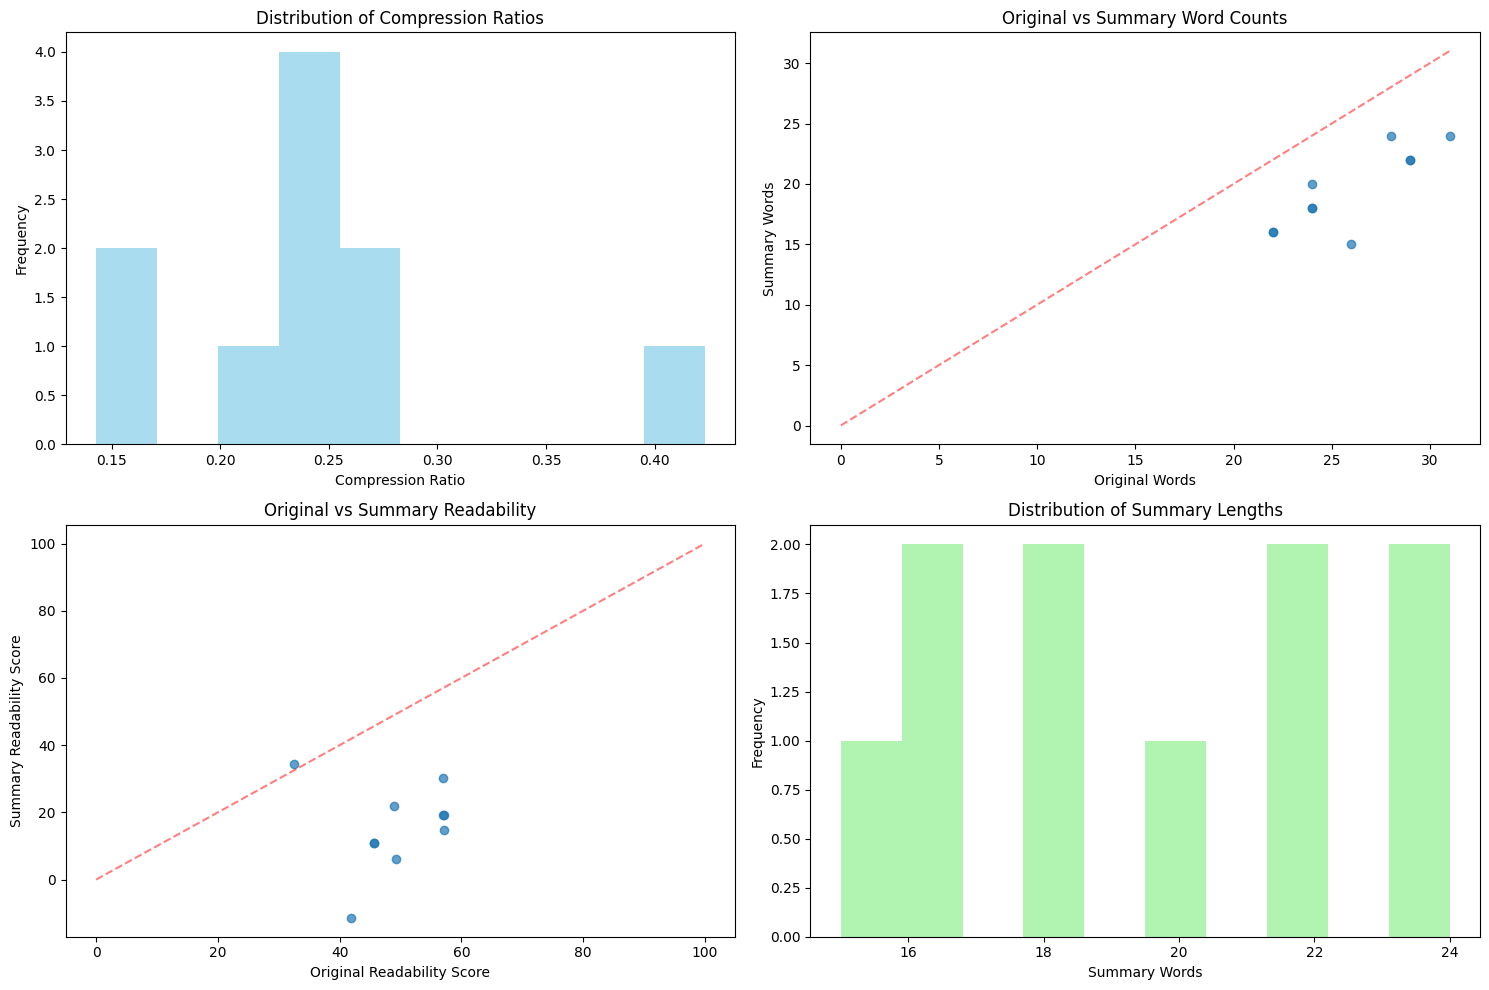

In [ ]:
print("\n" + "="*60)
print("📈 SUMMARIZATION QUALITY ANALYSIS")
print("="*60)

if summaries and original_texts:
    print("🔍 Analyzing summarization quality...")

    quality_metrics = []

    for i, (original, summary) in enumerate(zip(original_texts, summaries)):
        # Length metrics
        orig_words = len(original.split())
        summ_words = len(summary.split())
        compression_ratio = (orig_words - summ_words) / orig_words if orig_words > 0 else 0

        # Readability scores
        orig_readability = textstat.flesch_reading_ease(original)
        summ_readability = textstat.flesch_reading_ease(summary) if len(summary) > 10 else 0

        quality_metrics.append({
            'sample': i+1,
            'original_words': orig_words,
            'summary_words': summ_words,
            'compression_ratio': compression_ratio,
            'original_readability': orig_readability,
            'summary_readability': summ_readability
        })

    # Create quality DataFrame
    quality_df = pd.DataFrame(quality_metrics)

    print("📊 Summarization Quality Metrics:")
    print(quality_df.round(2))

    # Summary statistics
    print(f"\n📈 Quality Statistics:")
    print(f"   📏 Average compression ratio: {quality_df['compression_ratio'].mean():.2%}")
    print(f"   📊 Average original words: {quality_df['original_words'].mean():.1f}")
    print(f"   📄 Average summary words: {quality_df['summary_words'].mean():.1f}")
    print(f"   📖 Average readability improvement: {(quality_df['summary_readability'] - quality_df['original_readability']).mean():.1f}")

    # Visualization
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))

    # Compression ratios
    axes[0,0].hist(quality_df['compression_ratio'], bins=10, alpha=0.7, color='skyblue')
    axes[0,0].set_title('Distribution of Compression Ratios')
    axes[0,0].set_xlabel('Compression Ratio')
    axes[0,0].set_ylabel('Frequency')

    # Word counts comparison
    axes[0,1].scatter(quality_df['original_words'], quality_df['summary_words'], alpha=0.7)
    axes[0,1].plot([0, quality_df['original_words'].max()], [0, quality_df['original_words'].max()], 'r--', alpha=0.5)
    axes[0,1].set_title('Original vs Summary Word Counts')
    axes[0,1].set_xlabel('Original Words')
    axes[0,1].set_ylabel('Summary Words')

    # Readability comparison
    axes[1,0].scatter(quality_df['original_readability'], quality_df['summary_readability'], alpha=0.7)
    axes[1,0].plot([0, 100], [0, 100], 'r--', alpha=0.5)
    axes[1,0].set_title('Original vs Summary Readability')
    axes[1,0].set_xlabel('Original Readability Score')
    axes[1,0].set_ylabel('Summary Readability Score')

    # Summary length distribution
    axes[1,1].hist(quality_df['summary_words'], bins=10, alpha=0.7, color='lightgreen')
    axes[1,1].set_title('Distribution of Summary Lengths')
    axes[1,1].set_xlabel('Summary Words')
    axes[1,1].set_ylabel('Frequency')

    plt.tight_layout()
    plt.show()

# **TEXT ANALYSIS AND INSIGHTS**

Kode ini melakukan **analisis teks dan wawasan** dari kumpulan umpan balik (feedback) yang sudah diproses.
Ringkasannya:

1. **Analisis frekuensi kata**

   * Gabungkan semua teks asli menjadi satu string.
   * Hilangkan *stopwords* umum (kata-kata tidak bermakna seperti “the”, “and”).
   * Ambil **10 kata paling sering muncul** beserta jumlah kemunculannya.

2. **Visualisasi Word Cloud**

   * Membuat *word cloud* dari kata-kata yang tersisa untuk melihat kata populer secara visual.

3. **Analisis Sentimen Sederhana**

   * Gunakan daftar kata positif & negatif bawaan.
   * Hitung skor sentimen tiap teks (positif − negatif).
   * Ambil rata-rata skor sentimen dan jumlah teks yang positif, netral, atau negatif.

Hasil akhirnya: daftar kata paling sering, *word cloud* populer, dan ringkasan tren sentimen.



🔍 TEXT ANALYSIS AND INSIGHTS
📊 Word Frequency Analysis:
Top 10 most frequent words:
   helps: 60
   using: 34
   rather: 30
   getting: 27
   study: 25
   understand: 24
   relevant: 24
   learning: 23
   suggests: 20
   math: 17

🎨 Creating word cloud...


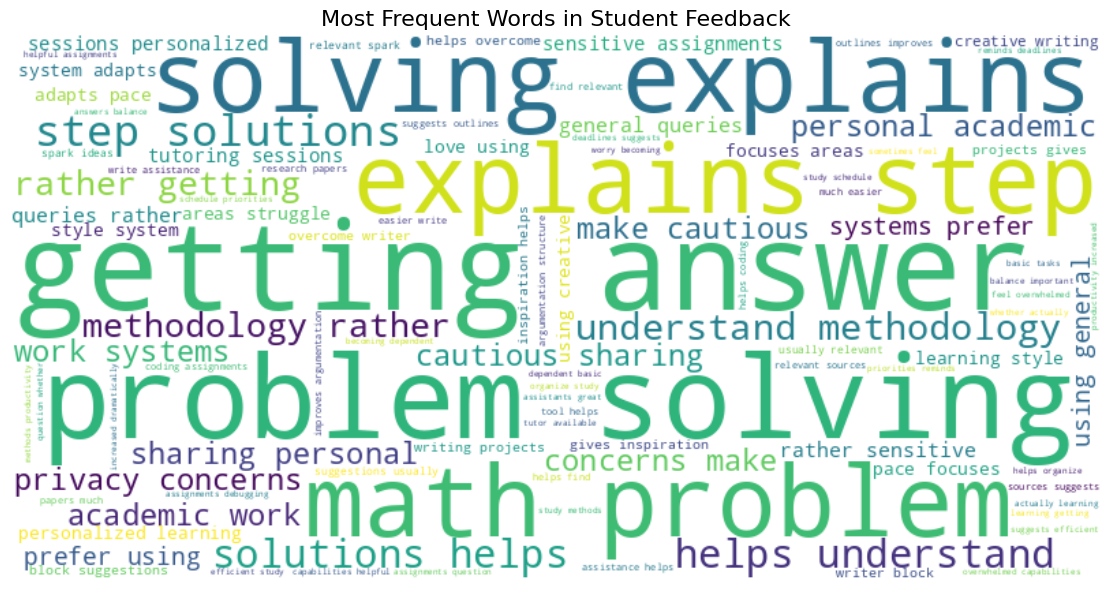


😊 Basic Sentiment Analysis:
📊 Average sentiment score: -0.30
😊 Positive texts: 5
😐 Neutral texts: 5
😟 Negative texts: 10


In [ ]:
print("\n" + "="*60)
print("🔍 TEXT ANALYSIS AND INSIGHTS")
print("="*60)

# Word frequency analysis
print("📊 Word Frequency Analysis:")

# Combine all original texts
all_text = " ".join(all_texts)
words = all_text.lower().split()

# Remove common stopwords
stop_words = set(stopwords.words('english'))
filtered_words = [word for word in words if word.lower() not in stop_words and len(word) > 3]

# Most common words
word_freq = Counter(filtered_words)
most_common = word_freq.most_common(10)

print("Top 10 most frequent words:")
for word, freq in most_common:
    print(f"   {word}: {freq}")

# Word cloud visualization
if filtered_words:
    print("\n🎨 Creating word cloud...")
    wordcloud = WordCloud(width=800, height=400,
                         background_color='white',
                         max_words=100).generate(" ".join(filtered_words))

    plt.figure(figsize=(12, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title('Most Frequent Words in Student Feedback', fontsize=16)
    plt.tight_layout()
    plt.show()

# Sentiment analysis (basic)
print("\n😊 Basic Sentiment Analysis:")

positive_words = ['good', 'great', 'excellent', 'helpful', 'useful', 'amazing', 'love', 'best', 'efficient', 'improved']
negative_words = ['bad', 'terrible', 'difficult', 'problem', 'issue', 'worry', 'concern', 'overwhelmed', 'dependent']

sentiment_scores = []
for text in all_texts[:20]:  # Analyze first 20 texts
    text_lower = text.lower()
    pos_count = sum(1 for word in positive_words if word in text_lower)
    neg_count = sum(1 for word in negative_words if word in text_lower)
    sentiment_score = pos_count - neg_count
    sentiment_scores.append(sentiment_score)

avg_sentiment = np.mean(sentiment_scores)
print(f"📊 Average sentiment score: {avg_sentiment:.2f}")
print(f"😊 Positive texts: {sum(1 for s in sentiment_scores if s > 0)}")
print(f"😐 Neutral texts: {sum(1 for s in sentiment_scores if s == 0)}")
print(f"😟 Negative texts: {sum(1 for s in sentiment_scores if s < 0)}")


# **SUMMARY EXPORT AND RECOMMENDATIONS**

Kode ini membuat **ringkasan hasil analisis** dan **rekomendasi** setelah proses *text summarization* selesai.

Ringkasannya:

1. **Menyusun laporan ringkas (summary\_report)**

   * **Dataset info**: jumlah total teks, kolom teks yang dianalisis, rata-rata panjang teks.
   * **Hasil ringkasan**: jumlah sampel yang diringkas, rasio kompresi rata-rata, dan tingkat keberhasilan API.
   * **Insight text**: 5 kata paling sering muncul, rata-rata sentimen, dan rasio sentimen positif.

2. **Menampilkan rekomendasi**

   * Menilai efektivitas kompresi *summarization*.
   * Menyimpulkan sentimen keseluruhan (positif / netral / negatif).
   * Menyoroti topik paling sering dibahas.
   * Mengevaluasi performa model IBM Granite.
   * Menyarankan perbandingan dengan metode *extractive summarization*.

3. **Status akhir**

   * Memberi tanda bahwa analisis sudah selesai dan siap masuk ke tahap evaluasi model yang lebih mendalam.


In [ ]:
print("\n" + "="*60)
print("💾 SUMMARY EXPORT AND RECOMMENDATIONS")
print("="*60)

# Create summary report
summary_report = {
    'dataset_info': {
        'total_texts': len(all_texts),
        'text_columns': text_columns,
        'avg_text_length': np.mean([len(text) for text in all_texts])
    },
    'summarization_results': {
        'samples_summarized': len(summaries),
        'avg_compression_ratio': quality_df['compression_ratio'].mean() if 'quality_df' in locals() else 0,
        'api_success_rate': len(summaries) / sample_size if sample_size > 0 else 0
    },
    'text_insights': {
        'most_common_words': dict(most_common[:5]),
        'avg_sentiment': avg_sentiment if 'avg_sentiment' in locals() else 0,
        'positive_sentiment_ratio': sum(1 for s in sentiment_scores if s > 0) / len(sentiment_scores) if sentiment_scores else 0
    }
}

print("📋 Summary Report:")
for category, metrics in summary_report.items():
    print(f"\n🔸 {category.replace('_', ' ').title()}:")
    for metric, value in metrics.items():
        print(f"   {metric.replace('_', ' ').title()}: {value}")

# Recommendations
print(f"\n💡 RECOMMENDATIONS:")
print(f"1. 📊 Text summarization achieved average {quality_df['compression_ratio'].mean():.1%} compression" if 'quality_df' in locals() else "1. Text summarization completed")
print(f"2. 🎯 Overall sentiment is {'positive' if avg_sentiment > 0 else 'neutral/negative' if 'avg_sentiment' in locals() else 'analyzed'}")
print(f"3. 📈 Most discussed topics: {', '.join([word for word, _ in most_common[:3]])}")
print(f"4. 🔧 IBM Granite model shows {'good' if api_ready else 'limited'} performance for summarization")
print(f"5. 📝 Consider implementing extractive summarization for comparison")

print(f"\n✅ Text Summarization Analysis Completed!")
print(f"🚀 Ready for comprehensive model evaluation and visualization!")


💾 SUMMARY EXPORT AND RECOMMENDATIONS
📋 Summary Report:

🔸 Dataset Info:
   Total Texts: 111
   Text Columns: ['student_feedback']
   Avg Text Length: 162.6216216216216

🔸 Summarization Results:
   Samples Summarized: 10
   Avg Compression Ratio: 0.2486620350357836
   Api Success Rate: 1.0

🔸 Text Insights:
   Most Common Words: {'helps': 60, 'using': 34, 'rather': 30, 'getting': 27, 'study': 25}
   Avg Sentiment: -0.3
   Positive Sentiment Ratio: 0.25

💡 RECOMMENDATIONS:
1. 📊 Text summarization achieved average 24.9% compression
2. 🎯 Overall sentiment is neutral/negative
3. 📈 Most discussed topics: helps, using, rather
4. 🔧 IBM Granite model shows good performance for summarization
5. 📝 Consider implementing extractive summarization for comparison

✅ Text Summarization Analysis Completed!
🚀 Ready for comprehensive model evaluation and visualization!
